In [16]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats, integrate
from scipy.stats import ttest_ind
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import re

In [17]:
# Dataset sample names

sample_info = pd.read_csv('HD_mRNASeq_sample_info.csv', sep=',', comment='#')

# Pull dataset ids, pull cap ids, pull control cap ids, pull hd cap ids respectively
dataset_ids = sample_info['Dataset.dataset_id'].tolist()
cap = [ _ for _ in dataset_ids if "CAP" in _]

# Biomart exported genes
en = pd.read_csv("mart_export.txt", sep="\t")
en = en.rename(columns = {'Gene stable ID':'gene_id'})

# All salmon counts BEFORE filtering and normalization
tsv = pd.read_csv("all_salmon_quant_rrna.tsv", sep="\t")

# All NORMALIZED counts from salmon (includes BA9 and CAP), filtered before normalization (HD mean >5 $ C mean >5/row)
df1 = pd.read_csv("all_salmon_norm.csv")

/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


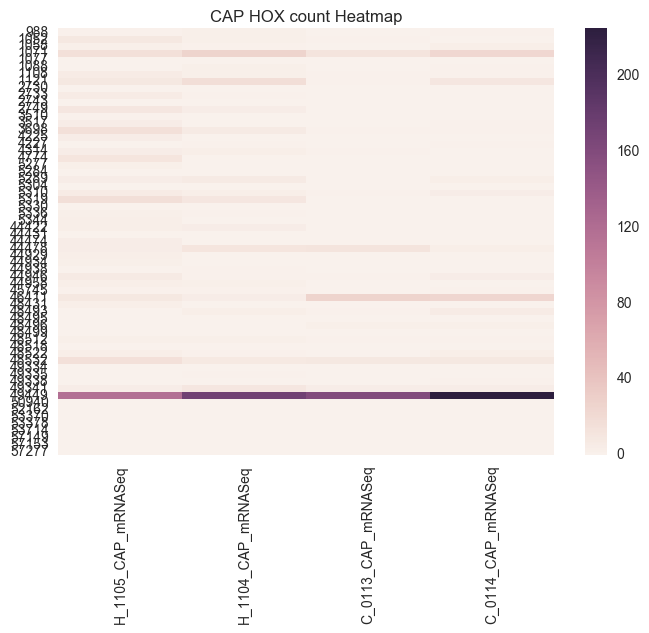

,gene_id,Gene name,HGNC symbol,H_1105_CAP_mRNASeq,H_1104_CAP_mRNASeq,C_0113_CAP_mRNASeq,C_0114_CAP_mRNASeq
988,ENSG00000105996,HOXA2,HOXA2,1.000000,2.00000,0.0000,1.000000
1052,ENSG00000122592,HOXA7,HOXA7,9.000000,2.00000,1.0000,0.865894
1058,ENSG00000254369,HOXA-AS3,HOXA-AS3,2.000000,1.00000,0.0000,3.134110
1071,ENSG00000106006,HOXA6,HOXA6,15.464700,26.12630,11.6469,23.524900
1077,ENSG00000197576,HOXA4,HOXA4,0.000000,0.00000,0.0000,0.000000
1088,ENSG00000253552,HOXA-AS2,HOXA-AS2,0.502247,2.00000,0.0000,1.000000
1108,ENSG00000105997,HOXA3,HOXA3,5.497750,2.00000,1.0000,1.000000
1121,ENSG00000106004,HOXA5,HOXA5,9.000000,18.00000,1.0000,10.000000
2730,ENSG00000257184,HOXA10-HOXA9,NaN,0.000000,0.00000,0.0000,0.000000
2733,ENSG00000078399,HOXA9,HOXA9,6.000000,1.00000,0.0000,0.000000


In [18]:
#### Finding HOX genes from all salmon counts (BEFORE filtering and normalization)

tcol = list(tsv)
tcol = tcol[:1] + cap
df_hox = tsv[tcol]
#df_hox = df_hox[(df_hox != 0).all(1)]

# uc2, copy of uc1 with HGNC gene names, 1142 rows due to dropping duplicates (genes with par_y)
df_hox['gene_id'] = df_hox['gene_id'].str.split('.').str[0]
df_hox = pd.merge(en, df_hox, on='gene_id')
df_hox.drop_duplicates()

# Pull out HOX gene names
hox = df_hox['Gene name'].tolist()
hox = [ _ for _ in hox if "HOX" in _]
hox = [ _ for _ in hox if _.startswith('H')]

# Pull counts for HOX genes
df_hox2 = df_hox[df_hox['Gene name'].isin(hox)]

## Heatmap on hox genes
hcol = list(df_hox2)
hcol = hcol[3:7]
heat = df_hox2[hcol]
sns.heatmap(heat)
plt.title("CAP HOX count Heatmap")
plt.show()

print()
#df_hox2.to_csv("HOX_CAP.csv", index=False)
df_hox2

In [19]:
###### CAP Ratios and fold change
###### H_1104/H_1105, H_1104/H_1105 2FC, C_0113/C_0114, C_0113/C_0114 2FC
###### [(H_1104+H_1105)/(C_0113/C_0114)], [(H_1104+H_1105)/(C_0113/C_0114)] 2FC

# column names of all counts
col = list(df1)
col = col[:1] + cap
df_cap = df1[col]
df_cap = df_cap[(df_cap != 0).all(1)]
#df_cap.to_csv("all_CAP_norm.csv", index=False)

# df_cap copy for use
df_cap1 = df_cap[(df_cap != 0).all(1)]

# H_1104/H_1105 ratio and log2 FC of ratio, C_0113/C_0114 ratio and log2 FC of ratio
df_cap1['H_CAP'] = df_cap1['H_1104_CAP_mRNASeq']/df_cap1['H_1105_CAP_mRNASeq']
df_cap1['C_CAP'] = df_cap1['C_0113_CAP_mRNASeq']/df_cap1['C_0114_CAP_mRNASeq']
df_cap1['H_CAP_L2FC'] = np.log2(df_cap1['H_CAP'])
df_cap1['C_CAP_L2FC'] = np.log2(df_cap1['C_CAP'])

# H/C ratio and log2 FC of ratio
df_cap1['H/C'] = (df_cap1['H_1104_CAP_mRNASeq']+ df_cap1['H_1105_CAP_mRNASeq'])/(df_cap1['C_0113_CAP_mRNASeq']+ df_cap1['C_0114_CAP_mRNASeq'])

# all_L2FC = LOG2(H1104+H1105/C113+C114), named as all since H/C_L2FC confuses python -> can't pull column into plot
df_cap1['all_L2FC'] = np.log2(df_cap1['H/C'])
#df_cap1.to_csv("all_CAP_FC.csv", index=False)

# Drop cap counts
df_cap1.drop([col for col in df_cap1.columns if 'mRNASeq' in col],axis=1,inplace=True)

# Remove inf, -inf, NA, and 0 from df
df_cap1 = df_cap1.replace([np.inf, -np.inf], np.nan)
df_cap1 = df_cap1.dropna()
df_cap1 = df_cap1[(df_cap1 != 0).all(1)]
#df_cap1.to_csv("all_CAPFC_wo_counts.csv", index=False)

/Users/Mojito/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gene_id       ENSG00000000003.14
H_CAP                 9.6709e-10
C_CAP                7.09735e-10
H_CAP_L2FC              -29.9456
C_CAP_L2FC               -30.392
H/C                    0.0340189
all_L2FC                -4.87752
Entropy                  0.29313
dtype: object
gene_id       ENSG00000283696.1
H_CAP               4.46524e+06
C_CAP               1.49284e+09
H_CAP_L2FC              22.0903
C_CAP_L2FC              30.4754
H/C                     58.8423
all_L2FC                5.87878
Entropy                       2
dtype: object


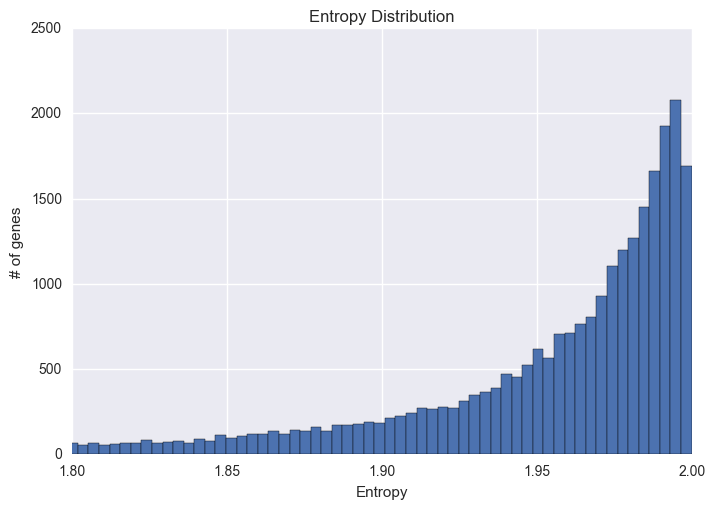

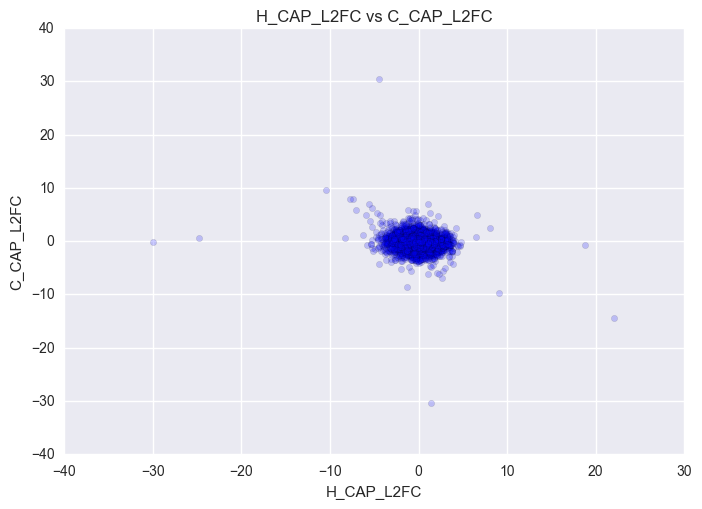

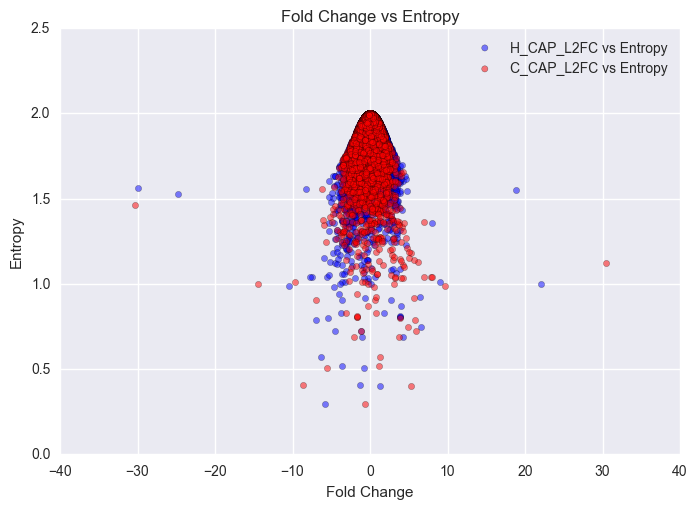

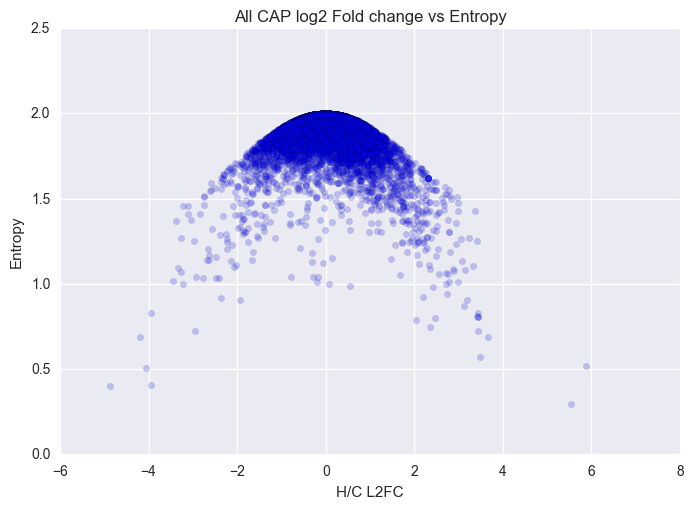

In [20]:
###### Entropy values
### p_i = sample/sum of all sample counts
### sum of all p_i = 1
### H = - sum of (p_i log p_i)

# Sum of gene counts
col = list(df1)
col = col[:1] + cap

# All CAP samples from all_salmon_norm.csv/ ALL GENE ROW SUM (probability), 27881 rows
df3 = df1[col]
df3.loc[:,'H_1105_CAP_mRNASeq':'C_0114_CAP_mRNASeq'] = df3.loc[:,'H_1105_CAP_mRNASeq':'C_0114_CAP_mRNASeq'].div(df3.sum(axis=1), axis=0)
assert((df3.sum(axis=1))==1).all

# Calculating entropy, 27243 rows after na dropped
df4 = df3
df4.loc[:,'H_1105_CAP_mRNASeq':'C_0114_CAP_mRNASeq']= -df3[cap] * np.log2(df3[cap])
df4["Entropy"] = df4.sum(axis=1)
df4 = df4.dropna()

# Drop all other columns than entropy
fix = list(df4)
fix = fix[:1] + fix[-1:]
ent = df4[fix]

# make new df using merge on gene_id
df_a = pd.merge(df_cap1, ent, on='gene_id')
df_a = df_a.dropna()
#df_a.to_csv("all_CAP_FC_Ent.csv", index=False)

print(df_a.min())
print(df_a.max())

# entropy
plt.hist(df_a["Entropy"], bins=500)
plt.axis([1.8,2,0,2500])
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("# of genes")
plt.show()

print()
# plot H1104/H1105 L2FC with C113/C114 L2FC
plt.scatter(df_a['H_CAP_L2FC'], df_a["C_CAP_L2FC"], alpha=0.2)
plt.title("H_CAP_L2FC vs C_CAP_L2FC")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("C_CAP_L2FC")
plt.show()

print()
# plot H_CAP FC against entropy and C_CAP FC against entropy as scatter
h = df_a['H_CAP_L2FC']
c = df_a['C_CAP_L2FC']
e = df_a['Entropy']
df = pd.DataFrame({"h":h, "c":c, "e":e})
ax = df.plot(kind="scatter", x="h",y="e", color="b", label="H_CAP_L2FC vs Entropy", alpha=0.5)
df.plot(kind="scatter", x="c",y="e", color="r", label="C_CAP_L2FC vs Entropy", ax=ax, alpha=0.5)   
ax.set_title("Fold Change vs Entropy")
ax.set_xlabel("Fold Change")
ax.set_ylabel("Entropy")
plt.show()

print()
# plot FC against entropy as scatter
plt.scatter(df_a['all_L2FC'], df_a["Entropy"], alpha=0.2)
plt.title("All CAP log2 Fold change vs Entropy")
plt.xlabel("H/C L2FC")
plt.ylabel("Entropy")
plt.show()


/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


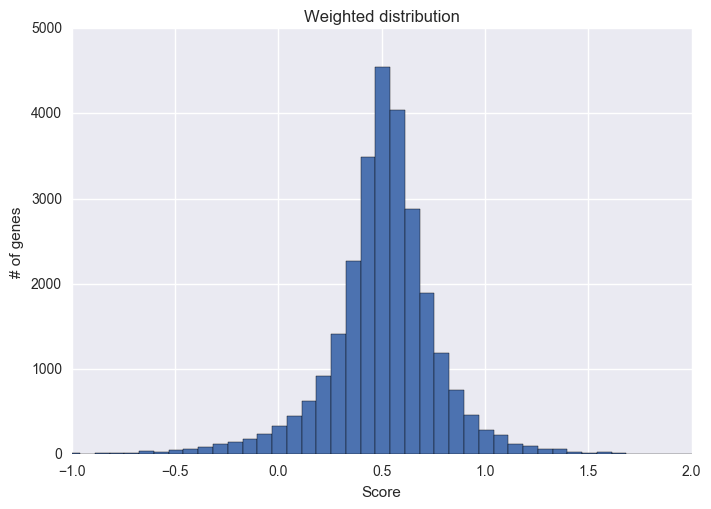

               gene_id  H_1105_CAP_mRNASeq  H_1104_CAP_mRNASeq  \
16   ENSG00000277117.4          143.688894          155.179978   
38   ENSG00000205358.3          342.625976          205.849335   
77   ENSG00000124935.3           18.024950            8.692799   
153  ENSG00000237436.1           12.016633            8.692799   
209  ENSG00000269138.1            6.009321            3.863466   
223  ENSG00000236627.1            0.858331            0.965867   

     C_0113_CAP_mRNASeq  C_0114_CAP_mRNASeq  H_CAP_L2FC  C_CAP_L2FC  all_L2FC  \
16            14.591889           14.249780    0.110994    0.034227  3.373286   
38            35.150635           42.363410   -0.735046   -0.269268  2.822897   
77             1.823416            1.556171   -1.052103    0.228643  2.982879   
153            1.823416            0.778086   -0.467140    1.228643  2.992871   
209           56.644611           28.789164   -0.637306    0.976413 -3.113277   
223            8.519922            8.558941    0.17

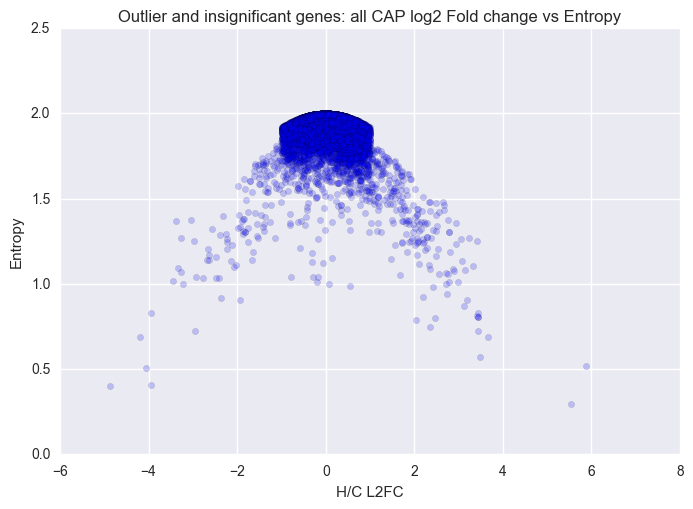

In [21]:
###### Manipulating df_a ###2 based on above scatter plots

# Pulling FC and Entropy values only, new 27243
column = list(df_a)
column = column[:1] + column[3:5] + column[6:]
new = df_a[column]
x = df_a[column]
x = x[column[1:]] * 0.25
new['Weighted'] = x.sum(axis=1)
#new['Weighted_FC'] = np.log2(new['Weighted'])
#new = new.dropna()

# All Weighted distribution
plt.hist(new["Weighted"], bins=200)
plt.axis([-1,2,0,5000])
plt.title("Weighted distribution")
plt.xlabel("Score")
plt.ylabel("# of genes")
plt.show()

###### Outliers 
### oc = outlier counts on left, FC on right
### Outliers based on H_L2FC AND C_L2FC, 1068 rows
outliers = new[((new.H_CAP_L2FC > 1)|(new.H_CAP_L2FC < -1)) & ((new.C_CAP_L2FC < -1)|(new.C_CAP_L2FC > 1))]

### Outliers based on H_L2FC OR C_L2FC values, 7549 rows
#outliers = new[(new.H_CAP_L2FC > 1)|(new.H_CAP_L2FC < -1)|(new.C_CAP_L2FC < -1)|(new.C_CAP_L2FC > 1)]
o = list(outliers)
o = o[:1]
oc = outliers[o]
#print(len(oc.index))

### NOT SIGNIFICANT, want only genes which are doubled or halved, 25740 genes
outlier = new[(new.all_L2FC > -1) & (new.all_L2FC < 1)]
o1 = list(outlier)
o1 = o1[:1]
oc1 = outlier[o1]
#print(len(oc1.index))

# Outlier, entropy < 1.5, 285 rows
outlier2 = new[(new.Entropy < 1.5)]
o2 = list(outlier2)
o2 = o2[:1]
oc2 = outlier2[o2]
oc2 = pd.merge(pd.merge(oc2,df_cap,on='gene_id'),new,on='gene_id')
#print(len(oc2.index))
#oc2.to_csv("CAP_outlier1.5.csv", index=False)

#### OUTLIER ANALYSIS using entropy < 1.5, above entropy 1.5 is pretty dense (where all the data are at)
# Row from excel, gene name, these genes have constant counts between themselves (H or C alone) 
# but different between H and C
# 18 ENSG00000277117.4, 40 ENSG00000205358.3, 79 ENSG00000124935.3, 155 ENSG00000237436.1, 211 ENSG00000269138.1
# and 225 ENSG00000236627.1
pull = [16,38,77,153,209,223]
a = oc2.ix[pull]
print(a)
# Analysis from above that I should use entropy < 1.4 for outliers, therefore entropy > 1.4 for usable data

# Outlier entropy < 1.4, 176 rows
outlier3 = new[(new.Entropy < 1.4)]
o3 = list(outlier3)
o3 = o3[:1]
oc3 = outlier3[o3]
#print(len(oc3.index))

# Merge both outliers into 1, drop duplicates if any, found 26,730 rows total
oc_t = pd.concat([oc,oc1,oc3])
oc_t = oc_t.drop_duplicates()
oc_t = pd.merge(pd.merge(oc_t,df_cap,on='gene_id'),new,on='gene_id')
#print(len(oc_t.index))

# plot FC against entropy as scatter
plt.scatter(oc_t['all_L2FC'], oc_t["Entropy"], alpha=0.2)
plt.title("Outlier and insignificant genes: all CAP log2 Fold change vs Entropy")
plt.axis([-6,8,0,2.5])
plt.xlabel("H/C L2FC")
plt.ylabel("Entropy")
plt.show()

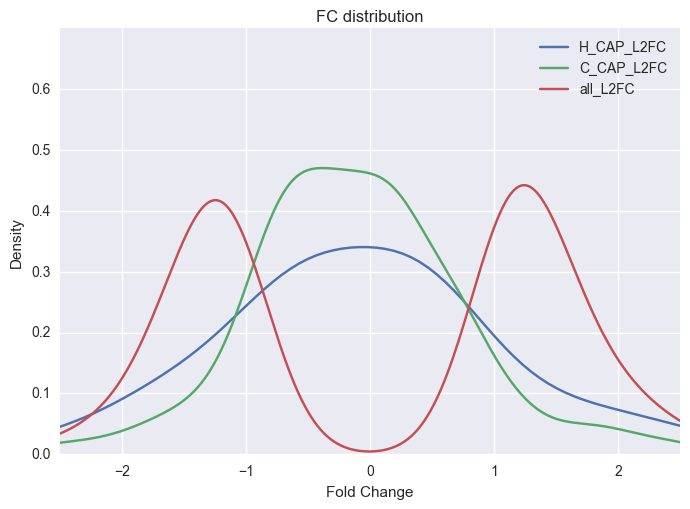

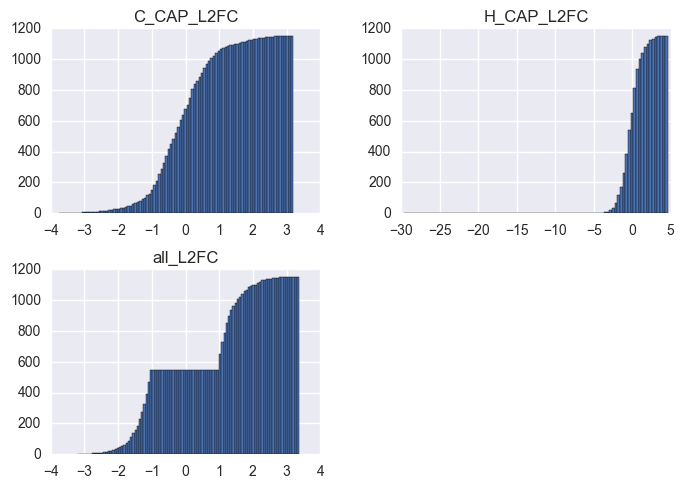

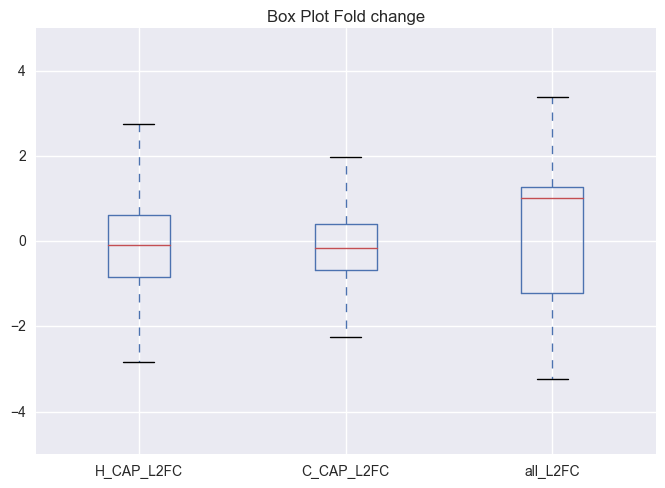

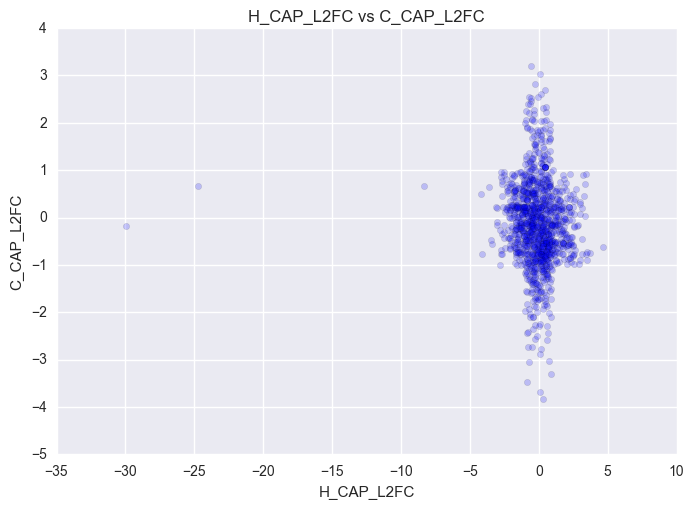

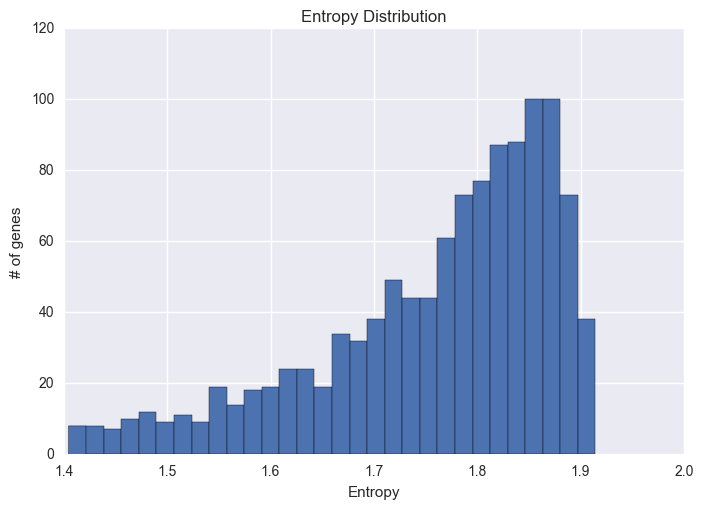

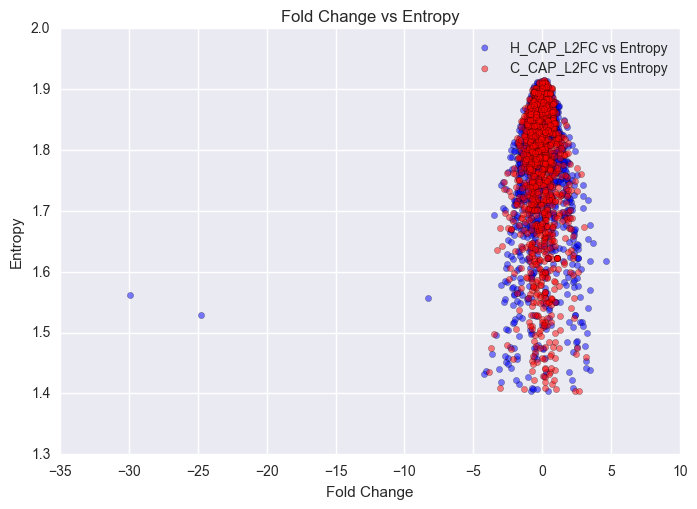

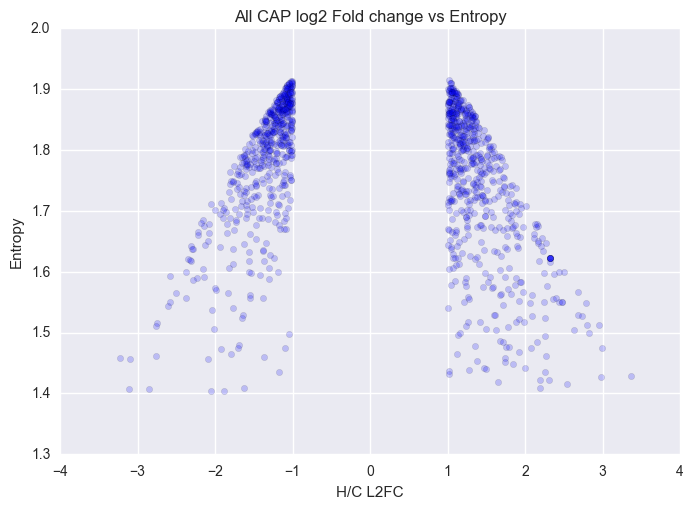

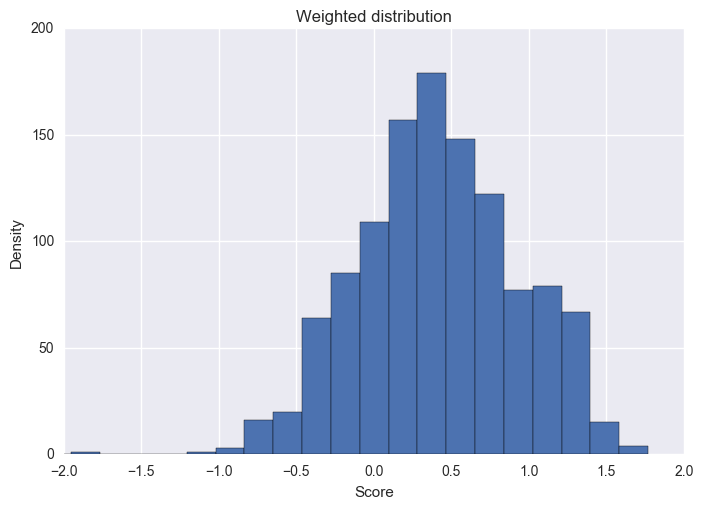

In [22]:
######  USABLE DATA, NOT OUTLIERS
### WEIGHTED = sum of  0.25*all columns

# outliers + insignificant gene names into a list
out = oc_t['gene_id'].values.tolist()

# use = 510 rows(with OR function instead of AND), pulls gene names not in out list
use = new[~new['gene_id'].isin(out)]
u1 = list(use)
u1 = u1[:1]
uc1 = use[u1]
# uc2 = copy of uc1
uc2 = pd.merge(pd.merge(uc1,df_cap,on='gene_id'),new,on='gene_id')
uc1 = pd.merge(pd.merge(uc1,df_cap,on='gene_id'),new,on='gene_id')
uc1.drop([col for col in uc1.columns if 'mRNASeq' in col],axis=1,inplace=True)
#uc1.to_csv("use2b_CAP_norm.csv", index=False)

# uc2, copy of uc1 with HGNC gene names, 1142 rows due to dropping duplicates (genes with par_y)
uc2['gene_id'] = uc2['gene_id'].str.split('.').str[0]
uc2 = pd.merge(en, uc2, on='gene_id')
uc2.drop_duplicates()
#uc2.to_csv("use2a_CAP_norm.csv", index=False)

# FC Distribution
c1 = ['H_CAP_L2FC','C_CAP_L2FC','all_L2FC']
c2 = uc1[c1]
c2.plot.kde()
plt.axis([-2.5,2.5,0,0.7])
plt.title("FC distribution")
plt.xlabel("Fold Change")
plt.show()

# FC Cumulative distribution
print()
c2.hist(cumulative=True, bins=100)
plt.show()

# FC Box plot
print()
c2.plot.box()
plt.title("Box Plot Fold change")
plt.ylim(-5, 5)
plt.show()

print()
# plot H1104/H1105 L2FC with C113/C114 L2FC
plt.scatter(uc1['H_CAP_L2FC'], uc1["C_CAP_L2FC"], alpha=0.2)
plt.title("H_CAP_L2FC vs C_CAP_L2FC")
plt.xlabel("H_CAP_L2FC")
plt.ylabel("C_CAP_L2FC")
plt.show()

print()
# entropy
plt.hist(uc1['Entropy'], bins=30)
plt.title("Entropy Distribution")
plt.axis([1.4,2,0,120])
plt.xlabel("Entropy")
plt.ylabel("# of genes")
plt.show()

print()
# plot H_CAP FC against entropy and C_CAP FC against entropy as scatter
h = uc1['H_CAP_L2FC']
c = uc1['C_CAP_L2FC']
e = uc1['Entropy']
df = pd.DataFrame({"h":h, "c":c, "e":e})
ax = df.plot(kind="scatter", x="h",y="e", color="b", label="H_CAP_L2FC vs Entropy", alpha=0.5)
df.plot(kind="scatter", x="c",y="e", color="r", label="C_CAP_L2FC vs Entropy", ax=ax, alpha=0.5)   
ax.set_title("Fold Change vs Entropy")
ax.set_xlabel("Fold Change")
ax.set_ylabel("Entropy")
plt.show()

print()
# plot all FC against entropy as scatter
plt.scatter(uc1['all_L2FC'], uc1['Entropy'], alpha=0.2)
plt.title("All CAP log2 Fold change vs Entropy")
plt.xlabel("H/C L2FC")
plt.ylabel("Entropy")
plt.show()

print()
# Weighted distribution
plt.hist(uc1['Weighted'], bins=50)
plt.title("Weighted distribution")
plt.axis([-2,2,0,200])
plt.xlabel("Score")
plt.ylabel("Density")
plt.show()

print()
#scatter_matrix(uc1, alpha=0.2, figsize=(6, 6), diagonal='kde')
#plt.show()

uc2['T-test Statistic'] = uc2.apply(lambda x:stats.ttest_ind(a=x[3:5], b=x[5:7],equal_var=False)[0],axis=1)
uc2['p-value'] = uc2.apply(lambda x:stats.ttest_ind(a=x[3:5], b=x[5:7],equal_var=False)[1],axis=1)
uc2.sort_values('p-value')

##### Convert output to files here (uncomment lines below)
#uc2.to_csv("use2c_CAP_norm.csv", index=False)
#uc2['Gene name'].to_csv("use2c_CAP_genes.csv", index=False)
#uc2['gene_id'].to_csv("use2c_CAP_geneid.csv", index=False)

In [26]:
#### Use "use2c_CAP_genes.csv" to find enriched genes in DAVID

david = pd.read_csv("use2c_genes_DAVID.txt",sep="\t")
david

Annotation Cluster 1  \
Category              Term                                               Count %                  PValue                 Genes                                              List Total Pop Hits Pop Total Fold Enrichment     Bonferroni                         Benjamini   
INTERPRO              IPR018064:Metallothionein, vertebrate, metal bi... 9     1.1936339522546418 5.95703408137209E-11   MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 526        11       18559     28.868129968890425  5.367288269386705E-8    5.367288269386705E-8   
UP_SEQ_FEATURE        region of interest:Alpha                           9     1.1936339522546418 3.4588767138110603E-10 MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 551        13       20063     25.20829261482619   5.260949801355608E-7    5.260949801355608E-7   
                      region of interest:Beta                            9     1.1936339522546418 3.4588767138110603E-10 MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 551        13       20063     25.20829261482619   5.260949801355608E-7    5.260949801355608E-7   
                      metal ion-binding site:Divalent metal cation; c... 9     1.1936339522546418 7.877088645271885E-10  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 551        14       20063     23.407700285195748  1.1981045168196758E-6   5.990524377663675E-7   
                      metal ion-binding site:Divalent metal cation; c... 9     1.1936339522546418 7.877088645271885E-10  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 551        14       20063     23.407700285195748  1.1981045168196758E-6   5.990524377663675E-7   
UP_KEYWORDS           Metal-thiolate cluster                             9     1.1936339522546418 8.087531551374729E-10  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 567        14       20581     23.334467120181404  3.162224417874171E-7   1.5811123332820642E-7   
INTERPRO              IPR023587:Metallothionein domain, vertebrate       9     1.1936339522546418 1.0056697552802746E-9  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 526        14       18559     22.68210211841391   9.061080524785936E-7   4.5305412887941543E-7   
                      IPR000006:Metallothionein, vertebrate              9     1.1936339522546418 1.0056697552802746E-9  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 526        14       18559     22.68210211841391   9.061080524785936E-7   4.5305412887941543E-7   
                      IPR003019:Metallothionein superfamily, eukaryotic  9     1.1936339522546418 1.0056697552802746E-9  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 526        14       18559     22.68210211841391   9.061080524785936E-7   4.5305412887941543E-7   
                      IPR017854:Metallothionein domain                   9     1.1936339522546418 1.0056697552802746E-9  MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F,... 526        14       18559     22.68210211841391   9.061080524785936E-7   4.5305412887941543E-7   
UP_KEYWORDS           Cadmium                                            7     0.9283819628647214 3.299189418989072E-8   MT1L, MT1A, MT1E, MT1H, MT1X, MT1G, MT1F           567        9        20581     28.2318244170096    1.289974764906443E-5    3.224952512703716E-6   
GOTERM_BP_DIRECT      GO:0071276~cellular response to cadmium ion        8     1.0610079575596816 2.233061660105239E-7   MT1A, HMOX1, MT1E, MT1H, MT1X, MT1G, MT1F, MT3     480        17       16792     16.462745098039214  5.54092399979389E-4      5.54092399979389E-4   
                      GO:0045926~negative regulation of growth           8     1.0610079575596816 5.505486278088756E-7   MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F     480        19       16792     14.72982456140351   0.0013655288861534887   6.829976859963338E-4   
                      GO:0071294~cellular response to zinc ion           8     1.0610079575596816 5.505486278088756E-7   MT1L, MT1A, MT2A, MT1E, MT1H, MT1X, MT1G, MT1F     480        19       1679